# Predictive Analysis #1

### In this notebook we will explore prototype and evaluate the ARIMA model for our time series data

In [18]:
import os
import sys
import math

import cufflinks
import numpy as np
import pandas as pd
# Standard plotly imports
import plotly.graph_objs as go
import seaborn as sns
from keras.layers import Dense
from keras.layers import LSTM
# univariate convlstm example
from keras.models import Sequential
from plotly.offline import iplot, init_notebook_mode
from sklearn import preprocessing

# Using plotly + cufflinks in offline mode
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")

# Using plotly + cufflinks in offline mode
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

DATASET_PATH = module_path + "/notebook/dt_agg1hour.h5"

dataset = pd.read_pickle(
    DATASET_PATH)

Using TensorFlow backend.


In [21]:
DATASET_PATH = module_path + "/notebook/dt_agg1hour.h5"
start_date = '2015-10-23'
end_date = '2015-10-25'

dataset = pd.read_pickle(
    DATASET_PATH)
dataset = dataset[start_date:end_date]

### The SARIMA method is denoted with the notation SARIMA(p, d, q).
### (p, d, q) ==> Seasonality, trend, and noise in data:

In [22]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Now we must perform a parameter selection of these three values by performing a grid search to find the optimal set that yields the minimum AIC

In [23]:
min_AIC = 100000000000000000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataset,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if results.aic < min_AIC:
                min_AIC = results.aic
                opt_AIC = (param, param_seasonal, results.aic)
                print('ARIMA{}x{}12 - AIC:{}'.format(opt_AIC[0], opt_AIC[1], opt_AIC[2]))

        except Exception as ex:
            print(ex)
            
            continue


c:\users\noresourses\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1127.1189290491861
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:929.8045421353271
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:923.5044984313228
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:705.9762808250366
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:701.1142719304883


c:\users\noresourses\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:689.6228028366219
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:658.0964685827624
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:646.3443368149387
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:625.7533946782023
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:623.3011134369708
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:597.6925789637311


In [24]:
print('ARIMA{}x{}12 - AIC:{}'.format(opt_AIC[0], opt_AIC[1], opt_AIC[2]))


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:597.6925789637311


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:44708.502669068235


In [25]:
mod = sm.tsa.statespace.SARIMAX(dataset,
                                order=(opt_AIC[0][0],opt_AIC[0][1], opt_AIC[0][2]),
                                seasonal_order=(opt_AIC[0][0],opt_AIC[1][1], opt_AIC[1][2], 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2963      0.165      1.797      0.072      -0.027       0.620
ma.S.L12      -0.5779      0.112     -5.168      0.000      -0.797      -0.359
sigma2      2.929e+04   6308.352      4.644      0.000    1.69e+04    4.17e+04


## Now, lets plot some diagnostics:

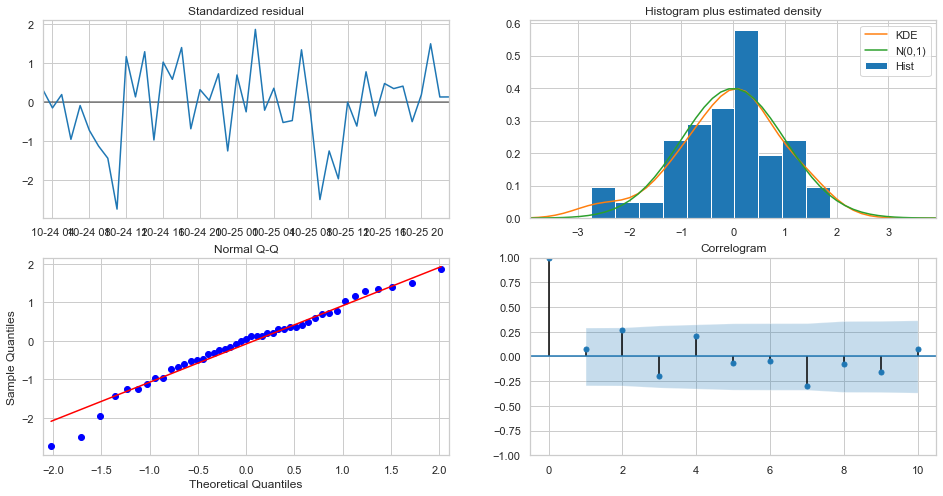

In [26]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

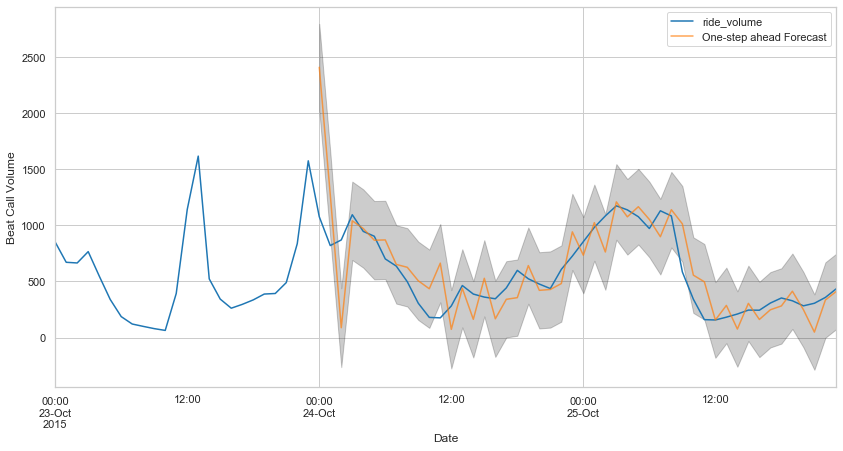

In [27]:
start_date = '2015-10-24'


pred = results.get_prediction(start=pd.to_datetime(start_date), dynamic=False)
pred_ci = pred.conf_int()
ax = dataset['2015-10-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Beat Call Volume')
plt.legend()
plt.show()

In [28]:
y_forecasted = pred.predicted_mean
y_truth = dataset['ride_volume'][start_date:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 82286.6


In [29]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 286.86


# As you can see from the above graphs we have managed to generate some decent results with the SARIMA method